In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch_geometric.transforms as T
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

In [63]:
edges_df = pd.read_csv("./wits2/tmp/2011/el_no_missing.csv")
locations_df = pd.read_csv("./wits2/data/common/locations.csv")
nodes_df = pd.read_csv("./wits2/tmp/2011/nl_no_missing.csv")

In [65]:
edges_df = pd.read_csv("./wits2/data/2011/edgelist_threshold.csv")

In [66]:
edges_df

,source,target,weight
0,MEX,COL,5.628647e+06
1,MEX,CAN,1.043998e+07
2,MEX,PRT,3.321739e+05
3,MEX,ARE,3.532589e+05
4,MEX,HND,4.997932e+05
...,...,...,...
3412,BIH,AUT,4.402657e+05
3413,BIH,ITA,6.855669e+05
3414,BIH,SVN,5.028449e+05
3415,BIH,HRV,8.568068e+05


In [67]:
#nodes_df.set_index('country_iso3', inplace=True)

In [68]:
nodes_df

,country_iso3,gdp_us_dollar,inflation_rate,gdp_growth,area,landlocked,continent,langoff_1,population,gdp_per_capita,agriculture_forestry_fishing_of_gdp,industry_of_gdp,merchandise_of_gdp,net_barter_of_trade,foreign_direct_investment_inflows
0,AFG,1.780429e+10,11.804186,0.426355,652225,1,Asia,Persian,30117411,591.162798,23.743664,22.740252,38.704149,144.751869,5.217342e+07
1,AGO,1.117897e+11,13.482468,3.471976,1246700,0,Africa,Portuguese,24220660,4615.468219,5.845681,56.026515,78.305971,244.329152,-3.023771e+09
2,ALB,1.289077e+10,3.429123,2.545322,28748,0,Europe,Albanian,2905195,4437.142885,18.226765,24.484408,56.862411,94.337202,1.048707e+09
3,ARE,3.506660e+11,0.877347,6.930272,83657,0,Asia,Arabic,8946778,39194.672240,0.671910,58.035599,151.702461,176.149781,7.152096e+09
4,ARG,5.301633e+11,9.800000,6.003952,2766889,0,America,Spanish,41261490,12848.864197,6.998734,25.212698,29.871929,160.564925,1.083993e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,WSM,7.374017e+08,5.235416,4.173393,2842,0,Pacific,Samoan,187469,3933.459357,8.836995,18.584138,55.871854,80.565436,8.984743e+06
162,YEM,3.272642e+10,19.543562,-12.714823,547244,0,Asia,Arabic,23807586,1374.621401,8.533169,46.466096,64.046119,171.430685,-5.178429e+08
163,ZAF,4.164189e+11,5.017158,3.284168,1219912,0,Africa,English,52003759,8007.476439,2.285473,26.942540,56.012110,146.294834,4.139289e+09
164,ZMB,2.345952e+10,6.429397,5.564602,752614,1,Africa,English,14023199,1672.907535,9.648058,34.444282,68.965619,197.447040,1.108500e+09


In [70]:
attribute_dict = nodes_df.set_index('country_iso3')['gdp_us_dollar'].to_dict()


In [71]:
#Drop edges that specify internal trade
edges_df.drop(edges_df[edges_df['source'] == edges_df['target']].index, inplace=True)

In [72]:
nodes_df = pd.merge(left=nodes_df, right=locations_df, how='inner', left_on='country_iso3', right_on='Alpha-3code')
countries = nodes_df['country_iso3'].unique()

In [26]:
trade_data = np.zeros((len(countries), len(countries)))
for i in range(len(countries)):
    for j in range(len(countries)):
        temp = edges_df[
            (edges_df['source'] == countries[i]) & (edges_df['target'] == countries[j])
        ]
        if temp.shape[0] != 0:
            trade_data[i, j] += temp['weight']
            trade_data[j, i] += temp['weight']

C:\Users\kevijone\AppData\Local\Temp\ipykernel_42704\3559632128.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trade_data[i, j] += temp['weight']
C:\Users\kevijone\AppData\Local\Temp\ipykernel_42704\3559632128.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  trade_data[j, i] += temp['weight']


In [73]:
g = nx.from_pandas_edgelist(edges_df, source='source', target='target', edge_attr=True, create_using=nx.DiGraph)

In [74]:
nx.set_node_attributes(g, attribute_dict, 'gdp')


In [10]:
el = pd.read_csv("./wits2/data/2011/edgelist_threshold.csv")

In [77]:
# Convert NetworkX graph to PyG Data object
data = from_networkx(g, group_edge_attrs=['weight'], group_node_attrs=['gdp'])


In [78]:
data

Data(edge_index=[2, 3417], x=[154, 1], edge_attr=[3417, 1])

In [ ]:
graph = to_networkx(data, node_attrs=["x"])

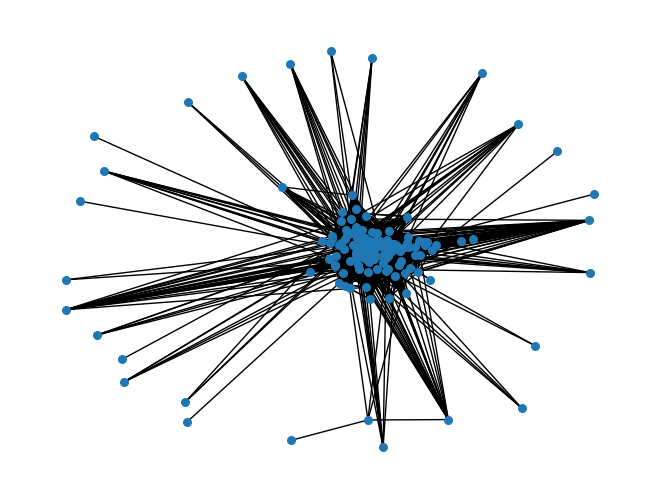

In [81]:
nx.draw_spring(graph, node_size=30, arrows=False)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, data.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

In [84]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(
            dim=-1
        )  # product of a pair of nodes on each edge

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [85]:
def train_link_predictor(
    model, train_data, val_data, optimizer, criterion, n_epochs=100
):

    for epoch in range(1, n_epochs + 1):

        model.train()
        optimizer.zero_grad()
        z = model.encode(train_data.x, train_data.edge_index)

        # sampling training negatives for every training epoch
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        edge_label_index = torch.cat(
            [train_data.edge_label_index, neg_edge_index],
            dim=-1,
        )
        edge_label = torch.cat([
            train_data.edge_label,
            train_data.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        out = model.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        val_auc = eval_link_predictor(model, val_data)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val AUC: {val_auc:.3f}")

    return model

In [101]:
model = Net(data.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()
model = train_link_predictor(model, train_data, val_data, optimizer, criterion)

test_auc = eval_link_predictor(model, test_data)
print(f"Test: {test_auc:.3f}")

Epoch: 010, Train Loss: 191027960415075684057088.000, Val AUC: 0.500
Epoch: 020, Train Loss: 189370473622616756191232.000, Val AUC: 0.500
Epoch: 030, Train Loss: 185941180664757727789056.000, Val AUC: 0.500
Epoch: 040, Train Loss: 187487662733601227669504.000, Val AUC: 0.500
Epoch: 050, Train Loss: 185926210699596348260352.000, Val AUC: 0.500
Epoch: 060, Train Loss: 187921917824070800375808.000, Val AUC: 0.500
Epoch: 070, Train Loss: 188435760527155264487424.000, Val AUC: 0.500
Epoch: 080, Train Loss: 189203750364411500429312.000, Val AUC: 0.500
Epoch: 090, Train Loss: 184978635323599086419968.000, Val AUC: 0.500
Epoch: 100, Train Loss: 183386090437766841106432.000, Val AUC: 0.500
Test: 0.500


In [87]:
@torch.no_grad()
def eval_link_predictor(model, data):

    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()

    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [97]:
split = T.RandomLinkSplit(
    num_val=0.05,
    num_test=0.1,
    is_undirected=False,
    add_negative_train_samples=False,
    neg_sampling_ratio=1.0,
)
train_data, val_data, test_data = split(data)

In [98]:
train_data

Data(edge_index=[2, 2906], x=[154, 1], edge_attr=[2906, 1], edge_label=[2906], edge_label_index=[2, 2906])

In [99]:
val_data


Data(edge_index=[2, 2906], x=[154, 1], edge_attr=[2906, 1], edge_label=[340], edge_label_index=[2, 340])

In [100]:
test_data

Data(edge_index=[2, 3076], x=[154, 1], edge_attr=[3076, 1], edge_label=[682], edge_label_index=[2, 682])